In [2]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import importlib
importlib.reload(energy_models)

<module 'energy_models' from '/home/scrotti/Aptamer2025py/energy_models.py'>

In [449]:
L, q = 3, 2

h = torch.randn(L, q)
J_ = torch.randn(L*q, L*q)
J_ = J_ + J_.t()
J = J_.reshape(L, q, L, q)
mask = torch.ones(L, q, L, q, device=J.device)
# set the (i,i) blocks to zero
mask[torch.arange(L), :, torch.arange(L), :] = 0
# J = J * mask

In [450]:
def energy(J, h, x):
    return energy_models.Potts(J.clone(), h.clone()).compute_energy(x)

In [451]:
def zerosum_old(J, h):
    J = J.clone()
    h = h.clone()
    
    K = J.mean(dim=3) * (-1.0)   # shape: (L, q, L)
    
    # transform J
    for i in range(L):
        for j in range(L):
            if i == j:
                continue
            J[i, :, j, :] += K[i, :, j].unsqueeze(1)
            J[i, :, j, :] += K[j, :, i].unsqueeze(0)
    
    # transform h
    for i in range(L):
        for j in range(L):
            if i == j:
                continue
            h[i] -= K[i, :, j]

    # final per-site constant removal
    h -= h.mean(dim=1, keepdim=True)

    return J, h

def zerosum_new(J, h):
    J = J.clone()
    mask = torch.ones(L, q, L, q, device=J.device)
    mask[torch.arange(J.shape[0]), :, torch.arange(J.shape[0]), :] = 0
    Jmasked = J * mask
    h = h.clone()

    dh = 0.5 * (Jmasked.mean(3).sum(2) + Jmasked.mean(1).sum(0) + Jmasked.mean(3).mean(1, keepdim=True).sum(2))
    dJ = Jmasked.mean(3, keepdim=True) + Jmasked.mean(1, keepdim=True) + Jmasked.mean((1,3), keepdim=True)
    J -= dJ
    h += dh
    h -= h.mean(dim=1, keepdim=True)

    return J, h

In [461]:
Jmasked = J * mask
dJ = Jmasked.mean(3, keepdim=True) + Jmasked.mean(1, keepdim=True) + Jmasked.mean((1,3), keepdim=True)

In [452]:
J1, h1 = zerosum_old(J, h)

In [453]:
J2, h2 = zerosum_new(J, h)

In [454]:
(J1 - J2).abs().max()

tensor(0.6755)

In [455]:
(h1 - h2).abs().max()

tensor(1.1921e-07)

In [456]:
M = 10
x_ = torch.randint(q, (M, L))
x = one_hot(x_)

In [457]:
e = energy(J, h, x)
e1 = energy(J1, h1, x)
e2 = energy(J2, h2, x)

In [458]:
e1 - e

tensor([-4.4071, -4.4071, -4.4071, -4.4071, -4.4071, -4.4071, -4.4071, -4.4071,
        -4.4071, -4.4071], grad_fn=<SubBackward0>)

In [459]:
e2 - e

tensor([-5.0846, -5.0846, -5.0846, -5.0846, -5.0846, -5.0846, -5.0846, -5.0846,
        -5.0846, -5.0846], grad_fn=<SubBackward0>)

In [192]:
en = potts.compute_energy(x)
potts_zerosum = potts.set_zerosum_gauge()
en_zerosum = potts_zerosum.compute_energy(x)
en - en_zerosum

tensor([4.3903, 4.3903, 4.3903, 4.3903, 4.3903], grad_fn=<SubBackward0>)

In [193]:
potts_zerosum.h

Parameter containing:
tensor([[-0.5751,  0.5751],
        [ 1.0849, -1.0849],
        [ 2.6169, -2.6169]], requires_grad=True)

In [194]:
params = {'bias': potts.h, 'coupling_matrix': potts.J}
params_zerosum = adabmDCA.dca.set_zerosum_gauge(params)

en_adabm = adabmDCA.statmech.compute_energy(x, params)
en_adabm_zerosum = adabmDCA.statmech.compute_energy(x, params_zerosum)
en_adabm - en_adabm_zerosum

tensor([3.9745, 4.2243, 0.0563, 4.2587, 3.9745], grad_fn=<SubBackward0>)

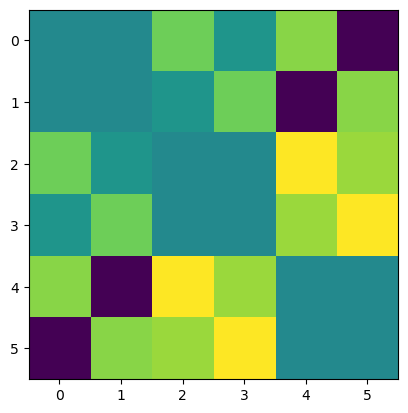

In [195]:
plt.imshow(potts_zerosum.J.reshape(L*q, L*q).detach().numpy())

In [167]:
torch.allclose(
    potts.J,
    potts.J.transpose(0,2).transpose(1,3)
)

True

In [168]:
torch.allclose(
    potts_zerosum.J,
    potts_zerosum.J.transpose(0,2).transpose(1,3)
)

True